In [1]:
%cd ..
%ls

C:\Users\Dongmin Kim\Documents\OnlineTSAD
 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: 067D-FB3E

 C:\Users\Dongmin Kim\Documents\OnlineTSAD 디렉터리

2023-05-10  오후 08:09    <DIR>          .
2023-05-10  오후 08:09    <DIR>          ..
2023-04-10  오후 01:01               156 .gitignore
2023-05-12  오후 06:11    <DIR>          .idea
2023-04-14  오후 04:53    <DIR>          .ipynb_checkpoints
2023-05-11  오전 08:56    <DIR>          cfgs
2023-05-04  오후 08:21    <DIR>          checkpoints
2023-05-11  오후 05:27    <DIR>          data
2023-05-11  오후 04:44    <DIR>          EDA
2023-05-11  오후 04:10    <DIR>          Exp
2023-05-12  오후 06:15    <DIR>          figures
2023-05-11  오후 05:30    <DIR>          hptune
2023-05-04  오후 08:21    <DIR>          logs
2023-05-07  오후 01:57    <DIR>          models
2023-05-11  오후 04:21    <DIR>          outputs
2023-05-04  오후 08:21    <DIR>          plots
2023-05-11  오후 05:51    <DIR>          results
2023-05-09  오후 06:11    <DIR>          scripts
2023-05-10  오후 08:09             

In [2]:
import numpy as np
import matplotlib as mat
from matplotlib import font_manager, rc

def setPlotStyle():    
    #mat.rcParams['font.family'] = "serif"
    #mat.rcParams['font.serif'] = ["Arial"]
    mat.rcParams['font.family'] = "sans-serif"
    mat.rcParams['font.sans-serif'] = "Times new roman"
    mat.rcParams["axes.titlesize"] = "x-large"
    mat.rcParams['font.size'] = 15
    mat.rcParams['legend.fontsize'] = 15
    mat.rcParams['lines.linewidth'] = 2
    mat.rcParams['lines.color'] = 'r'
    mat.rcParams['axes.grid'] = 1     
    mat.rcParams['axes.xmargin'] = 0.1     
    mat.rcParams['axes.ymargin'] = 0.1     
    mat.rcParams["mathtext.fontset"] = "dejavuserif" #"cm", "stix", etc.
    mat.rcParams['figure.dpi'] = 500
    mat.rcParams['savefig.dpi'] = 500
setPlotStyle()

In [3]:
import torch
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from utils.metrics import get_summary_stats

from models.MLP import MLP

import wandb
import hydra
from omegaconf import DictConfig

from utils.logger import make_logger
from utils.argpass import prepare_arguments, configure_exp_id
from utils.tools import SEED_everything, plot_interval

import warnings
from data.load_data import DataFactory
from Exp.MLP import *

from easydict import EasyDict as edict
import yaml
import re
import copy

warnings.filterwarnings("ignore")

# load yaml
cfg = {}
loader = yaml.SafeLoader
loader.add_implicit_resolver(
    u'tag:yaml.org,2002:float',
    re.compile(u'''^(?:
     [-+]?(?:[0-9][0-9_]*)\\.[0-9_]*(?:[eE][-+]?[0-9]+)?
    |[-+]?(?:[0-9][0-9_]*)(?:[eE][-+]?[0-9]+)
    |\\.[0-9_]+(?:[eE][-+][0-9]+)?
    |[-+]?[0-9][0-9_]*(?::[0-5]?[0-9])+\\.[0-9_]*
    |[-+]?\\.(?:inf|Inf|INF)
    |\\.(?:nan|NaN|NAN))$''', re.X),
    list(u'-+0123456789.'))

# get cfg
model = "MLP"
with open("cfgs/test_defaults.yaml", "r") as file:
    basic_config = yaml.load(file, Loader=loader)
    cfg.update(basic_config)
with open(f"cfgs/model/{model}.yaml", "r") as file:
    model_config = yaml.load(file, Loader=loader)
    cfg.update({"model": model_config})

In [4]:
cfg['dataset'] = 'SWaT'
cfg["RevIN"] = 'ARevIN'
cfg["gamma"] = 0.5
args = prepare_arguments(cfg)
print(args)

logger = make_logger(os.path.join(args.log_path, f'{args.exp_id}.log'))
logger.info(f"Configurations: {args}")

# Data
logger.info(f"Preparing {args.dataset} dataset...")
datafactory = DataFactory(args, logger)
train_dataset, train_loader, test_dataset, test_loader = datafactory()
args.num_channels = train_dataset.X.shape[1]
train_X, train_y, test_X, test_y = train_dataset.X, train_dataset.y, test_dataset.X, test_dataset.y

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

[2023-05-12 18:15:56,403] Configurations: {'exp_id': 'MLP_SWaT_normalization_None', 'infer_options': ['offline_all'], 'thresholding': 'q95.0', 'dataset': 'SWaT', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 12, 'eval_stride': 12, 'scaler': 'std', 'ttlr': 0.001, 'normalization': 'None', 'gamma': 0.5, 'log_freq': 10, 'checkpoint_path': './checkpoints\\MLP_SWaT_normalization_None', 'log_path': './logs\\MLP_SWaT_normalization_None', 'output_path': './outputs\\MLP_SWaT_normalization_None', 'plot_path': './plots\\MLP_SWaT_normalization_None', 'result_path': './results\\MLP_SWaT_normalization_None', 'plot_anomaly_scores': False, 'plot_recon_status': False, 'save_result': True, 'load_anoscs': True, 'save_outputs': False, 'save_roc_curve': True, 'defaults': [{'model': 'MLP'}], 'model': {'name': 'MLP', 'latent_dim': 128}, 'RevIN': 'ARevIN', 'home_dir': '.', 'device': device(type='cpu')}
[2023-05-12 18:15:56,404] Preparing SWaT dataset...
[2023-05-12 18:15:56,405] current 

{'exp_id': 'MLP_SWaT_normalization_None', 'infer_options': ['offline_all'], 'thresholding': 'q95.0', 'dataset': 'SWaT', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 12, 'eval_stride': 12, 'scaler': 'std', 'ttlr': 0.001, 'normalization': 'None', 'gamma': 0.5, 'log_freq': 10, 'checkpoint_path': './checkpoints\\MLP_SWaT_normalization_None', 'log_path': './logs\\MLP_SWaT_normalization_None', 'output_path': './outputs\\MLP_SWaT_normalization_None', 'plot_path': './plots\\MLP_SWaT_normalization_None', 'result_path': './results\\MLP_SWaT_normalization_None', 'plot_anomaly_scores': False, 'plot_recon_status': False, 'save_result': True, 'load_anoscs': True, 'save_outputs': False, 'save_roc_curve': True, 'defaults': [{'model': 'MLP'}], 'model': {'name': 'MLP', 'latent_dim': 128}, 'RevIN': 'ARevIN', 'home_dir': '.', 'device': device(type='cpu')}


[2023-05-12 18:16:05,915] train: X - (496800, 51), y - (496800,) test: X - (449919, 51), y - (449919,)
[2023-05-12 18:16:06,017] Complete.
[2023-05-12 18:16:06,018] Preparing dataloader...
[2023-05-12 18:16:06,556] total train dataset- 647, batch_X - torch.Size([64, 12, 51]), batch_y - torch.Size([64, 12])
[2023-05-12 18:16:06,557] total test dataset- 37494, batch_X - torch.Size([1, 12, 51]), batch_y - torch.Size([1, 12])
[2023-05-12 18:16:06,557] Complete.


(496800, 51) (496800,) (449928, 51) (449928,)


# figure 1: trajectories

In [5]:
data_df = pd.read_csv("data/SWaT/SWaT_Dataset_Attack_v0.csv", index_col=0)
cols = list(data_df.columns)
data_df

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
Timestamp,,,,,,,,,,,,,,,,,,,,,
28/12/2015 10:00:00 AM,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,2,...,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1,Normal
28/12/2015 10:00:01 AM,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,2,...,2,1,250.8652,1.649953,189.6789,0.000128,1,1,1,Normal
28/12/2015 10:00:02 AM,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,2,...,2,1,250.8812,1.649953,189.6789,0.000128,1,1,1,Normal
28/12/2015 10:00:03 AM,2.534350,522.9645,2,2,1,262.0161,8.394514,328.6337,2.442316,2,...,2,1,250.8812,1.649953,189.6148,0.000128,1,1,1,Normal
28/12/2015 10:00:04 AM,2.569260,523.4748,2,2,1,262.0161,8.394514,328.6337,2.443085,2,...,2,1,250.8812,1.649953,189.5027,0.000128,1,1,1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2/1/2016 2:59:55 PM,2.559972,519.5495,2,2,1,168.0979,8.638683,301.9226,2.459488,2,...,2,1,251.1535,0.865024,189.0220,0.000000,1,1,1,Normal
2/1/2016 2:59:56 PM,2.549082,520.4131,2,2,1,168.0979,8.638683,301.9226,2.459488,2,...,2,1,251.0734,0.865024,188.9259,0.000000,1,1,1,Normal
2/1/2016 2:59:57 PM,2.531467,520.6878,2,2,1,168.0979,8.638683,301.9226,2.460129,2,...,2,1,251.0734,0.865024,188.9259,0.000000,1,1,1,Normal


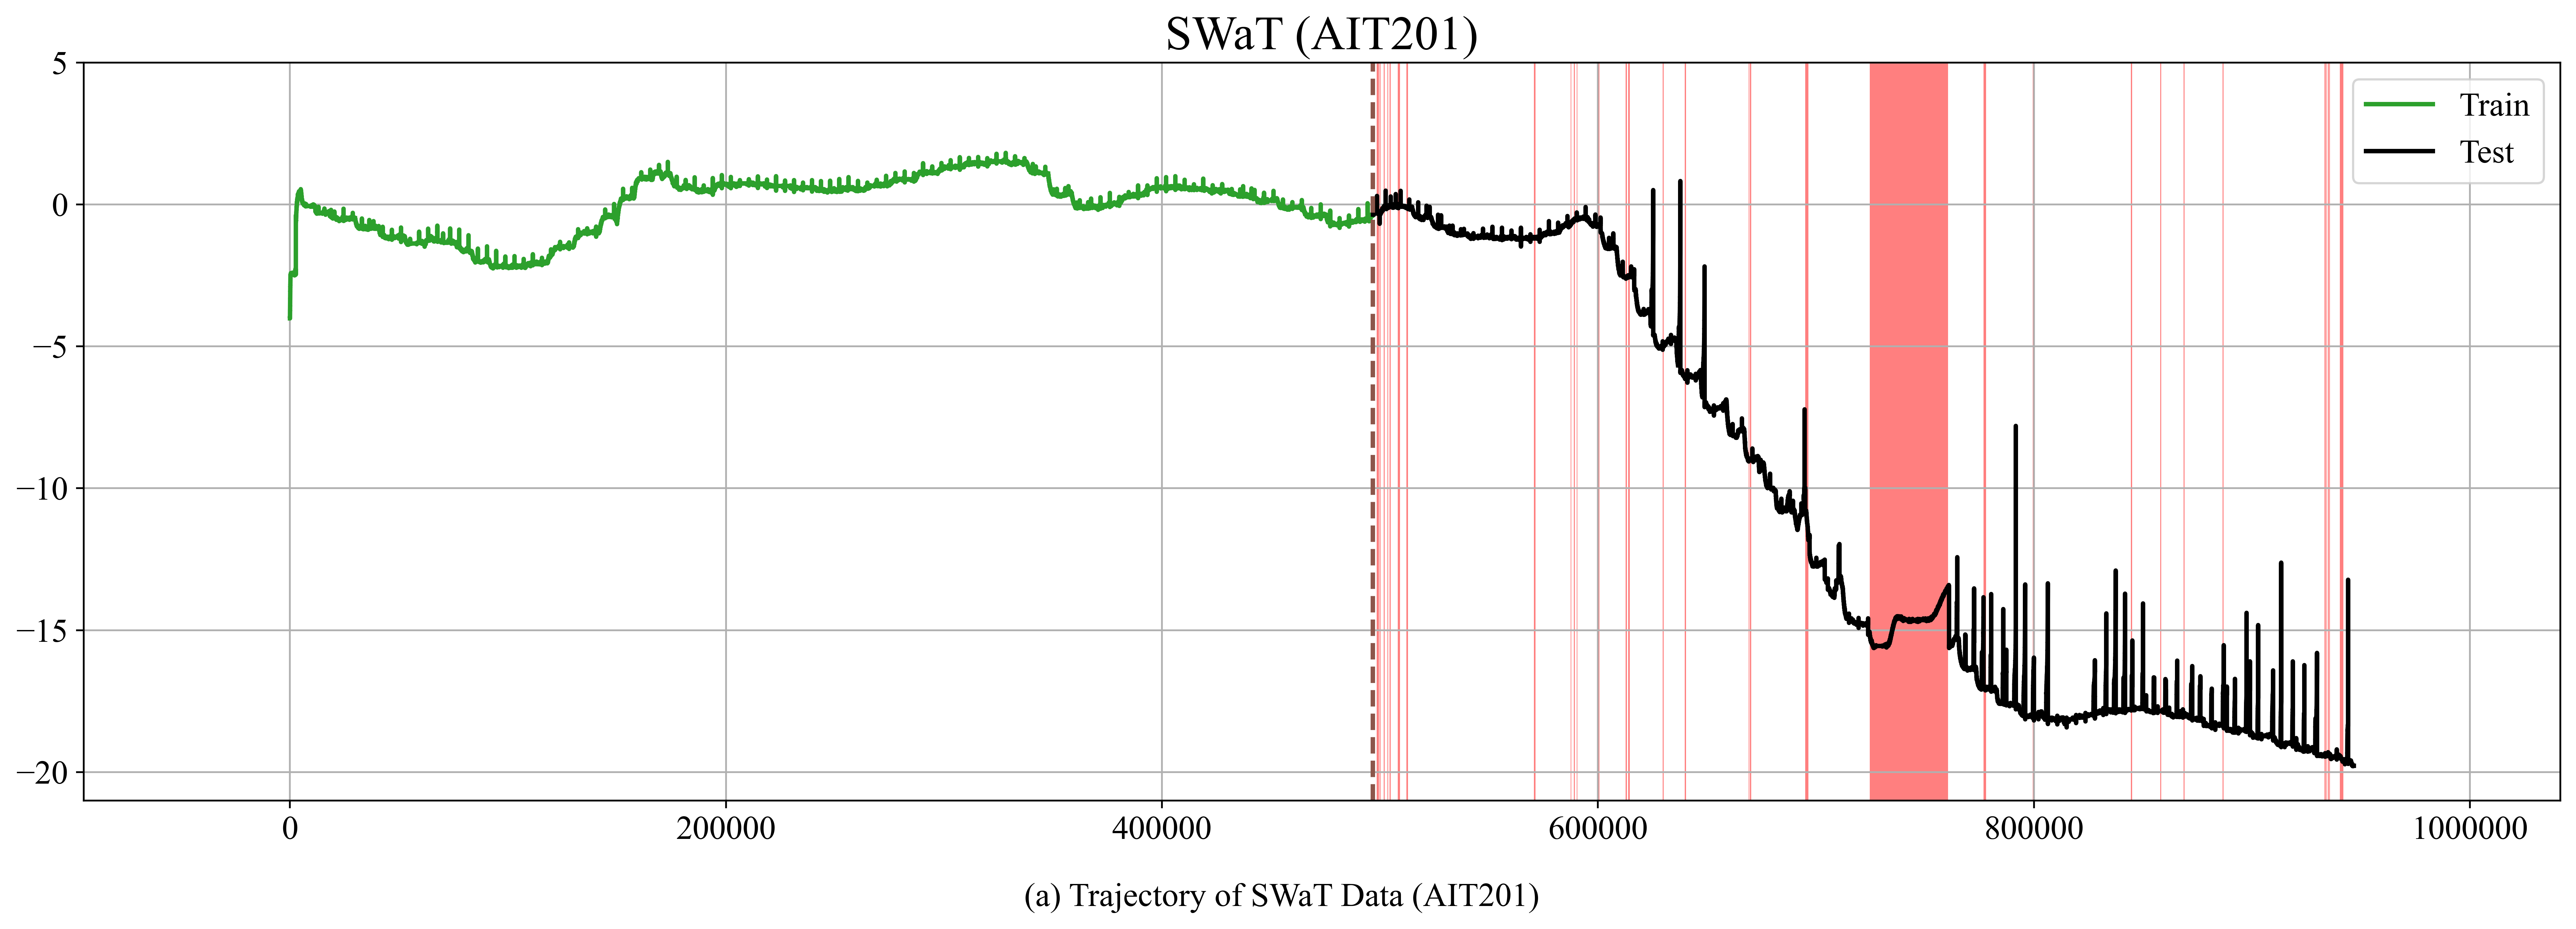

In [54]:
c = 5
dataset_name = "SWaT"

plt.figure(figsize=(20, 6), dpi=500)
plt.plot(train_X[:, c], color="C2", label="Train")
plt.plot(range(len(train_X), len(train_X)+len(test_X)), test_X[:, c], color="black", label="Test")
label = np.concatenate([np.array([0]*len(train_X)), test_y])
plot_interval(plt, label)

plt.ylim((-21,5))
plt.vlines(x=[len(train_X)], ymin=-21, ymax=5, ls="--", color="C5")
plt.title(f"SWaT (AIT201)")

plt.legend()
plt.ticklabel_format(style="plain")

plt.figtext(0.5, 0.0, f"(a) Trajectory of SWaT Data (AIT201)", fontsize=15, ha="center")
plt.show()

## Training statistics

In [5]:
args.output_path

'./outputs\\MLP_SWaT_normalization_None'

In [6]:
Xs_path = os.path.join(args.output_path, "Xs.pt")
with open(Xs_path, 'rb') as f:
    Xs = torch.load(f, map_location=torch.device('cpu'))
    
Xhats_offline_path = os.path.join(args.output_path, "Xhats_offline.pt")
with open(Xhats_offline_path, 'rb') as f:
    Xhats = torch.load(f, map_location=torch.device('cpu'))
    
online_path = os.path.join("outputs", "MLP_SWaT_normalization_Detrend")
Xhats_online_path = os.path.join(online_path, "Xhats_offline.pt")
with open(Xhats_online_path, 'rb') as f:
    Xhats_online = torch.load(f, map_location=torch.device('cpu'))

# Figure 2: Reconstructions

In [7]:
mat.rcParams['axes.xmargin'] = 0.05     
mat.rcParams['axes.ymargin'] = 0.05

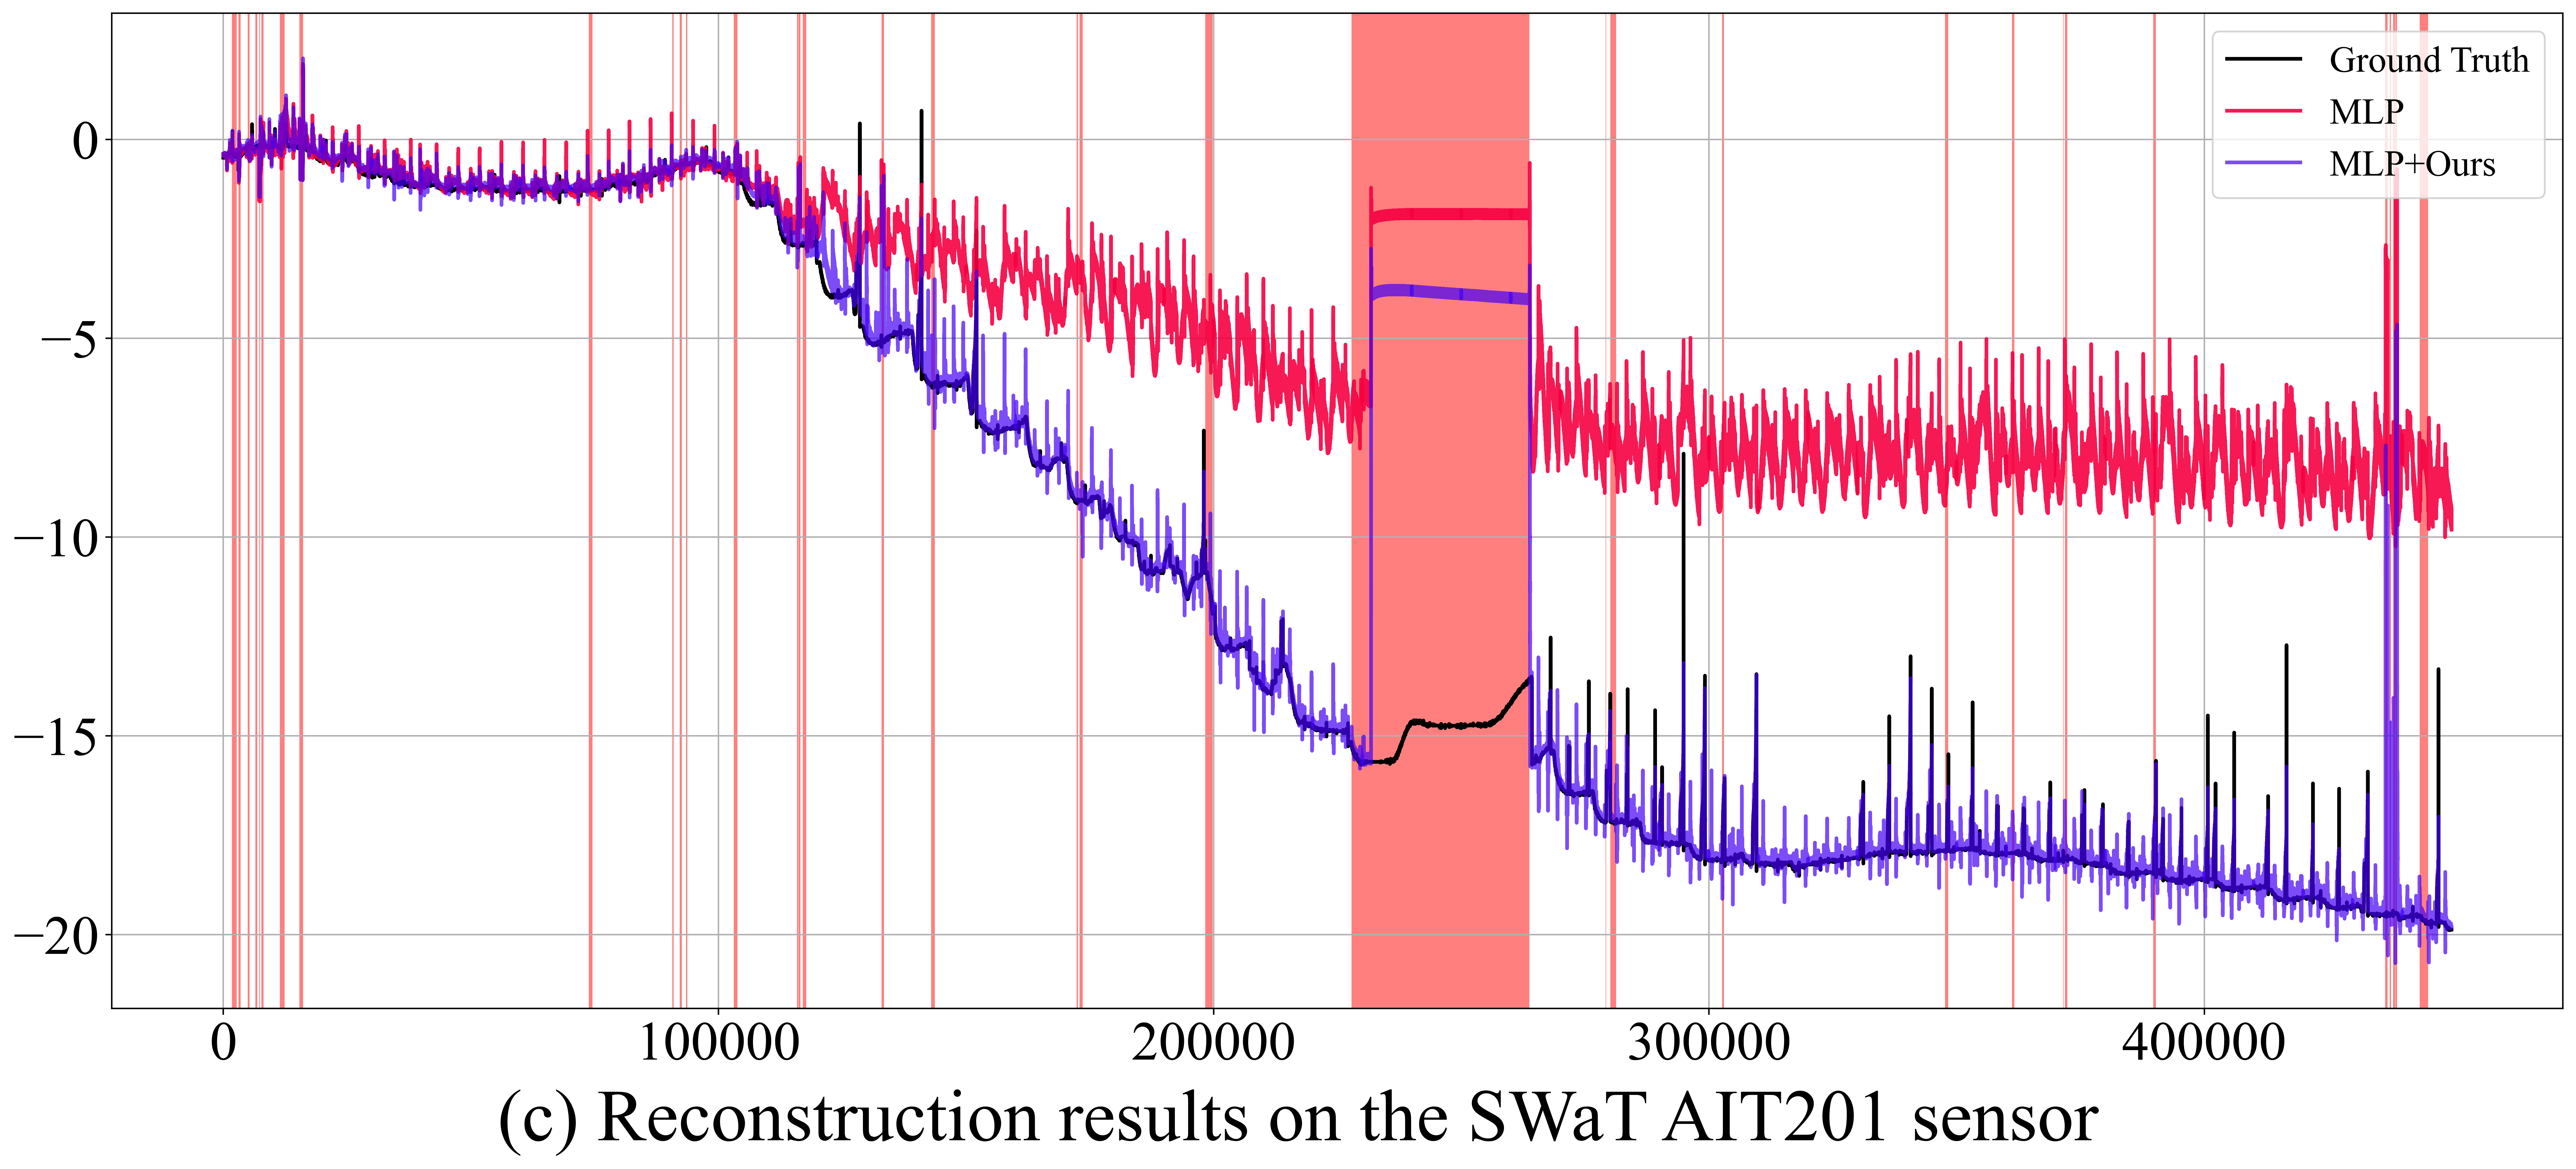

In [22]:
# plot recon
c = 5
test_X, test_y = test_dataset.X, test_dataset.y

B, L, C = Xhats.shape
s, e = 0, -1
plt.figure(figsize=(24, 10), dpi=500)
plt.plot(test_X[s:e, c]-0.1, color="black", label="Ground Truth")
plt.plot(Xhats[:,:,c].reshape(-1), color="#F60041", alpha=0.9, label="MLP")
plt.plot(Xhats_online[:,:,c].reshape(-1), color="#4400F6", alpha=0.7, label="MLP+Ours")
plt.legend(loc=1, fontsize=20)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.savefig("./figures/main_figure/recons.svg")
plt.figtext(0.5, 0.025, f"(c) Reconstruction results on the SWaT AIT201 sensor", fontsize=40, ha="center")
plot_interval(plt, test_y)

# Figure 3: Metrics

In [26]:
#models = ["MLP", "LSTMEncDec", "USAD", "THOC", "Anomaly\nTransformer", "MLP\n(with TTA)"]
#F1s = [0.7627968694, 0.4762438172, 0.7389041724, 0.7706859497, 0.2163872167, 0.7908998881]
models = ["MLP", "USAD", "THOC", "MLP\n(+Ours)"]
F1s = [0.7627968694,  0.7389041724, 0.7706859497, 0.7908998881]
hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']

In [45]:
def label_diff(ax, i,j,text,X,Y):
    x = (X[i]+X[j])/2
    y = 1.1*max(Y[i], Y[j])
    dx = abs(X[i]-X[j])

    props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':20,'shrinkB':20,'linewidth':2}
    ax.annotate(text, xy=(X[i],y), zorder=10)
    ax.annotate('', xy=(X[i],y), xytext=(X[j],y), arrowprops=props)

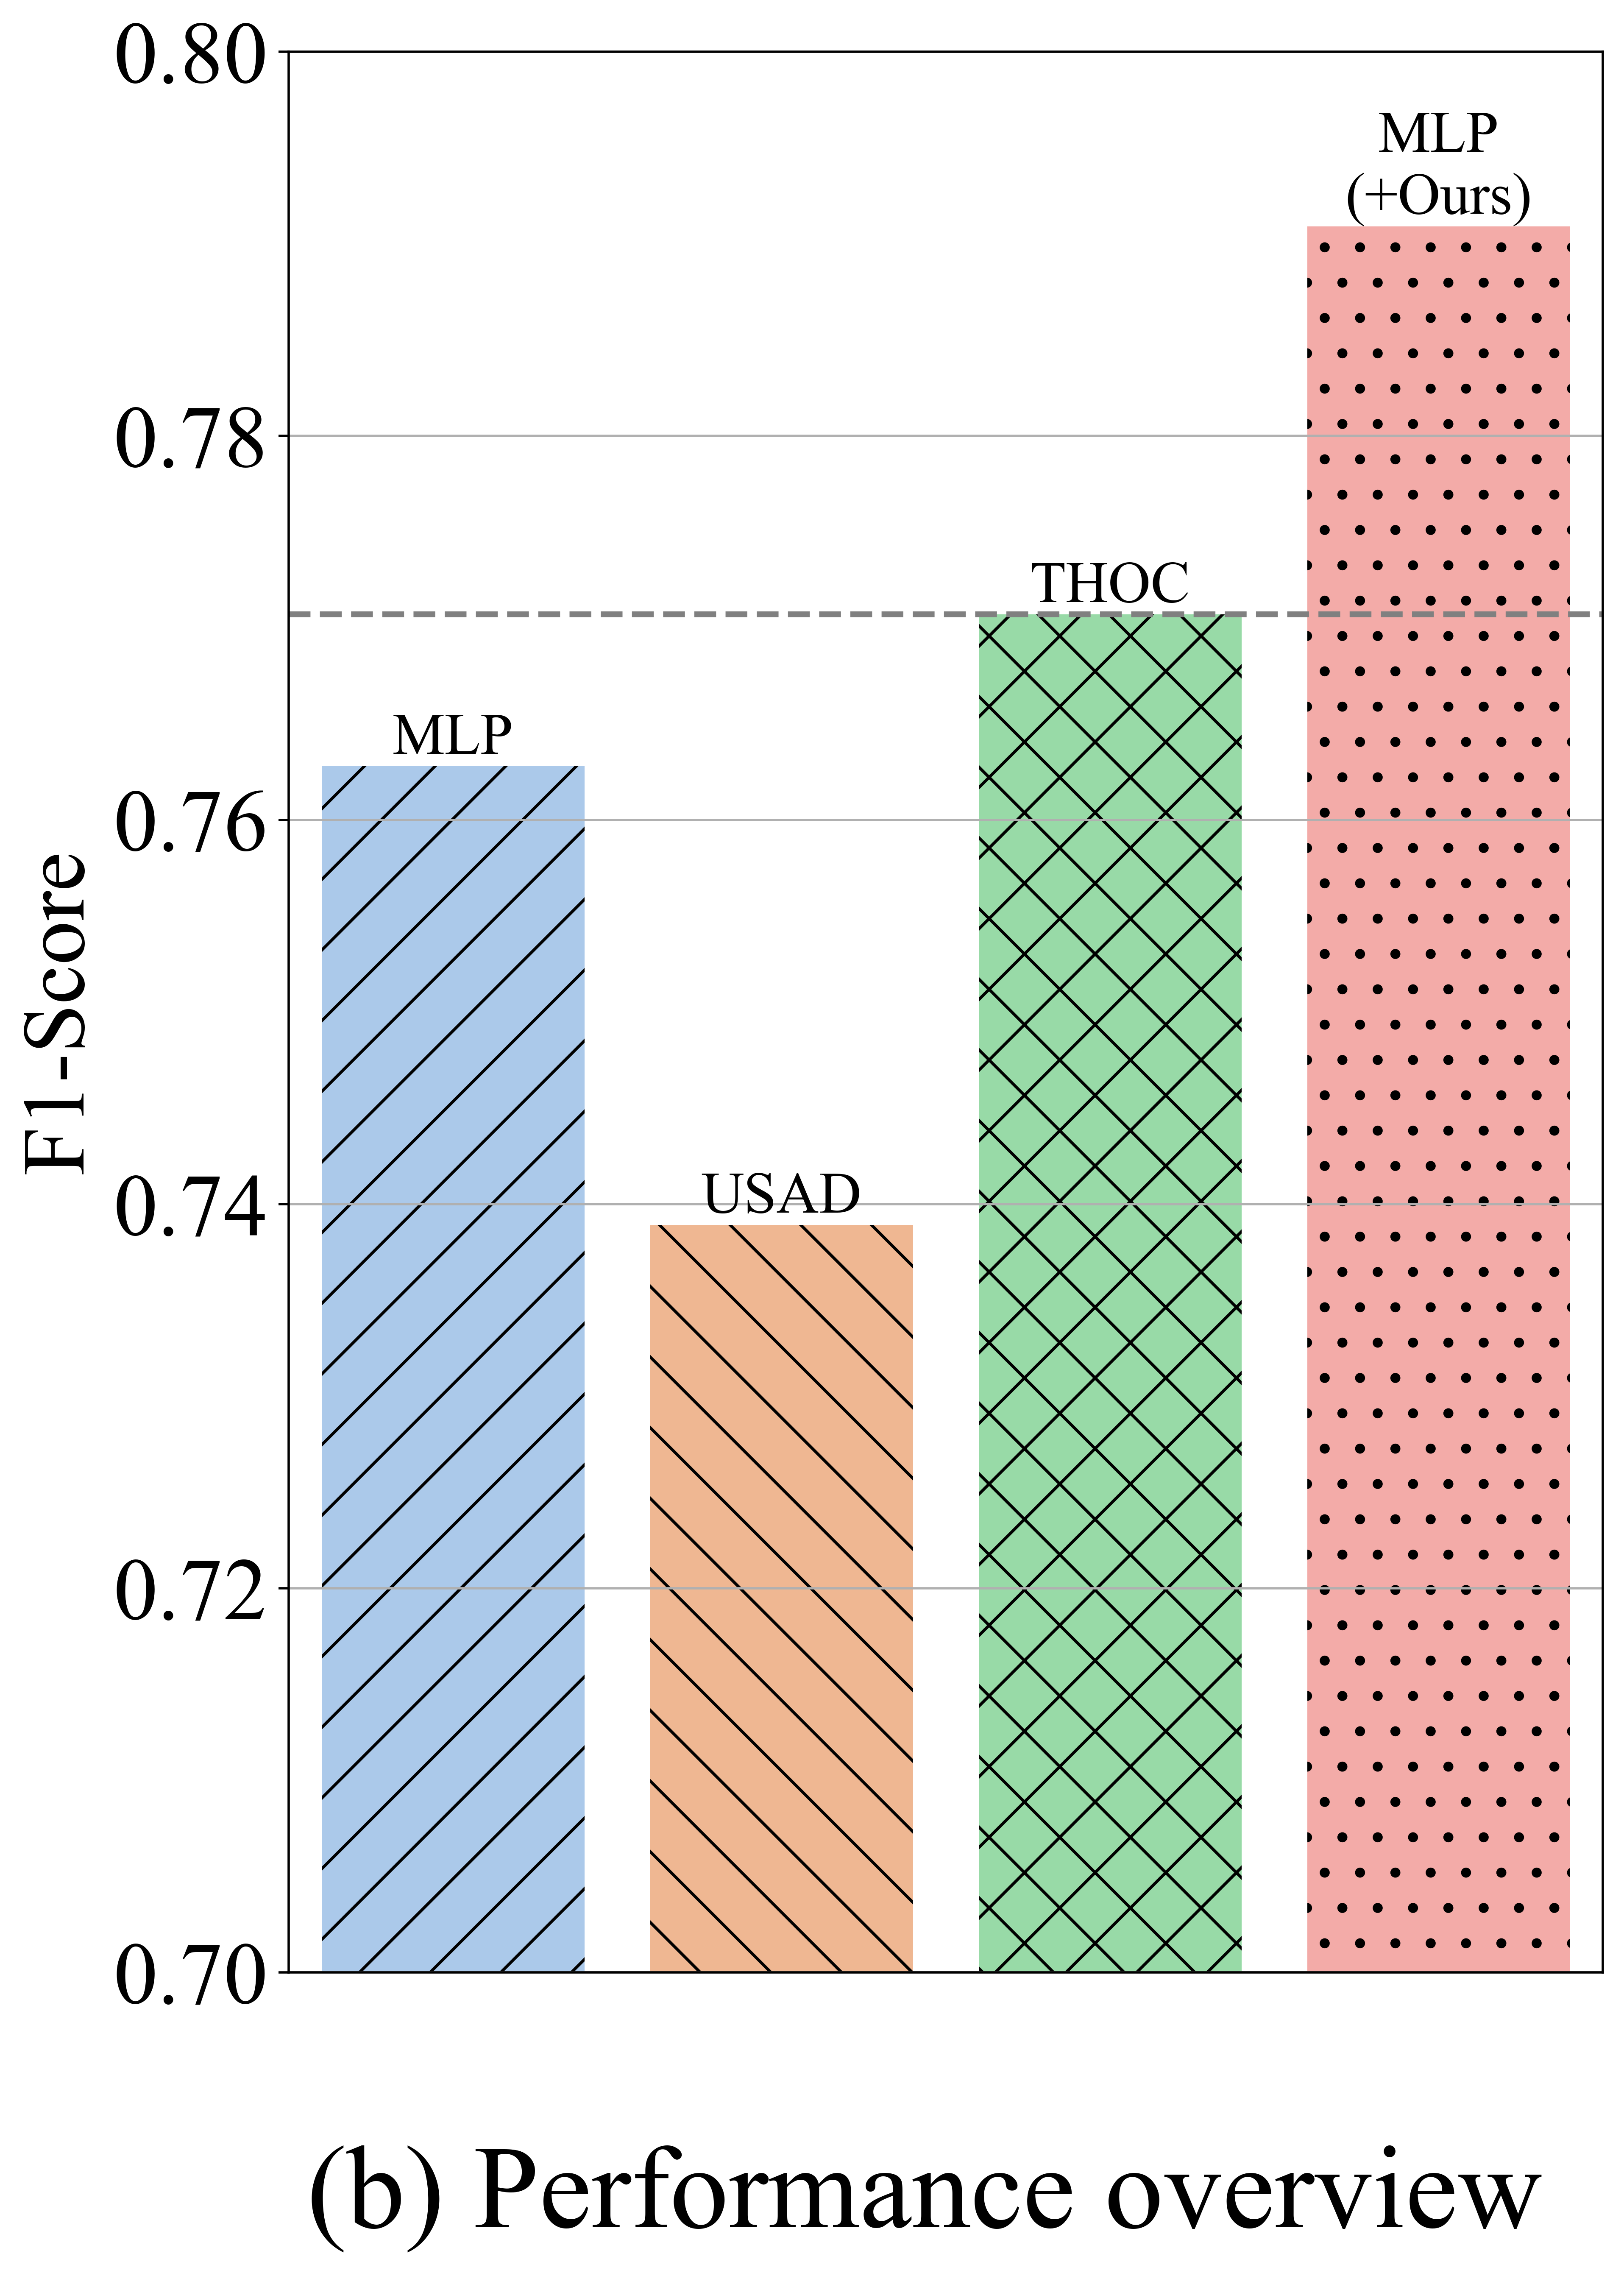

In [47]:
import pandas as pd
import seaborn as sns
plt.figure(figsize=(8, 12), dpi=500)
#plt.title('', fontsize=20)
plt.ylim((0.7, 0.8))
data = pd.DataFrame({"Models":models, "F1-Score": F1s})
data.set_index("Models")
ax = sns.barplot(y= "F1-Score", x = "Models", data = data, label=data["Models"], palette=("pastel"))
ax.axhline(0.7706859497, linestyle="--", color="gray")

label_diff(ax, 0,1,'p=0.0370',np.arange(4),F1s)



hatches=['/', '\\', 'x', '.']

for i, bar in enumerate(ax.patches):
    bar.set_hatch(hatches[i])

ax.bar_label(ax.containers[0], labels=models, fontsize=20)
    #for i in ax.containers:
#    ax.bar_label(i,)
#ax.legend()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(True)
ax.set(xlabel=None)
ax.xaxis.set_tick_params(labelsize=30)
ax.yaxis.label.set_fontsize(30)
ax.yaxis.set_tick_params(labelsize=30)

plt.savefig("./figures/main_figure/perf.svg")
plt.figtext(0.50, 0.025, f"(b) Performance overview", fontsize=40, ha="center")
plt.show()

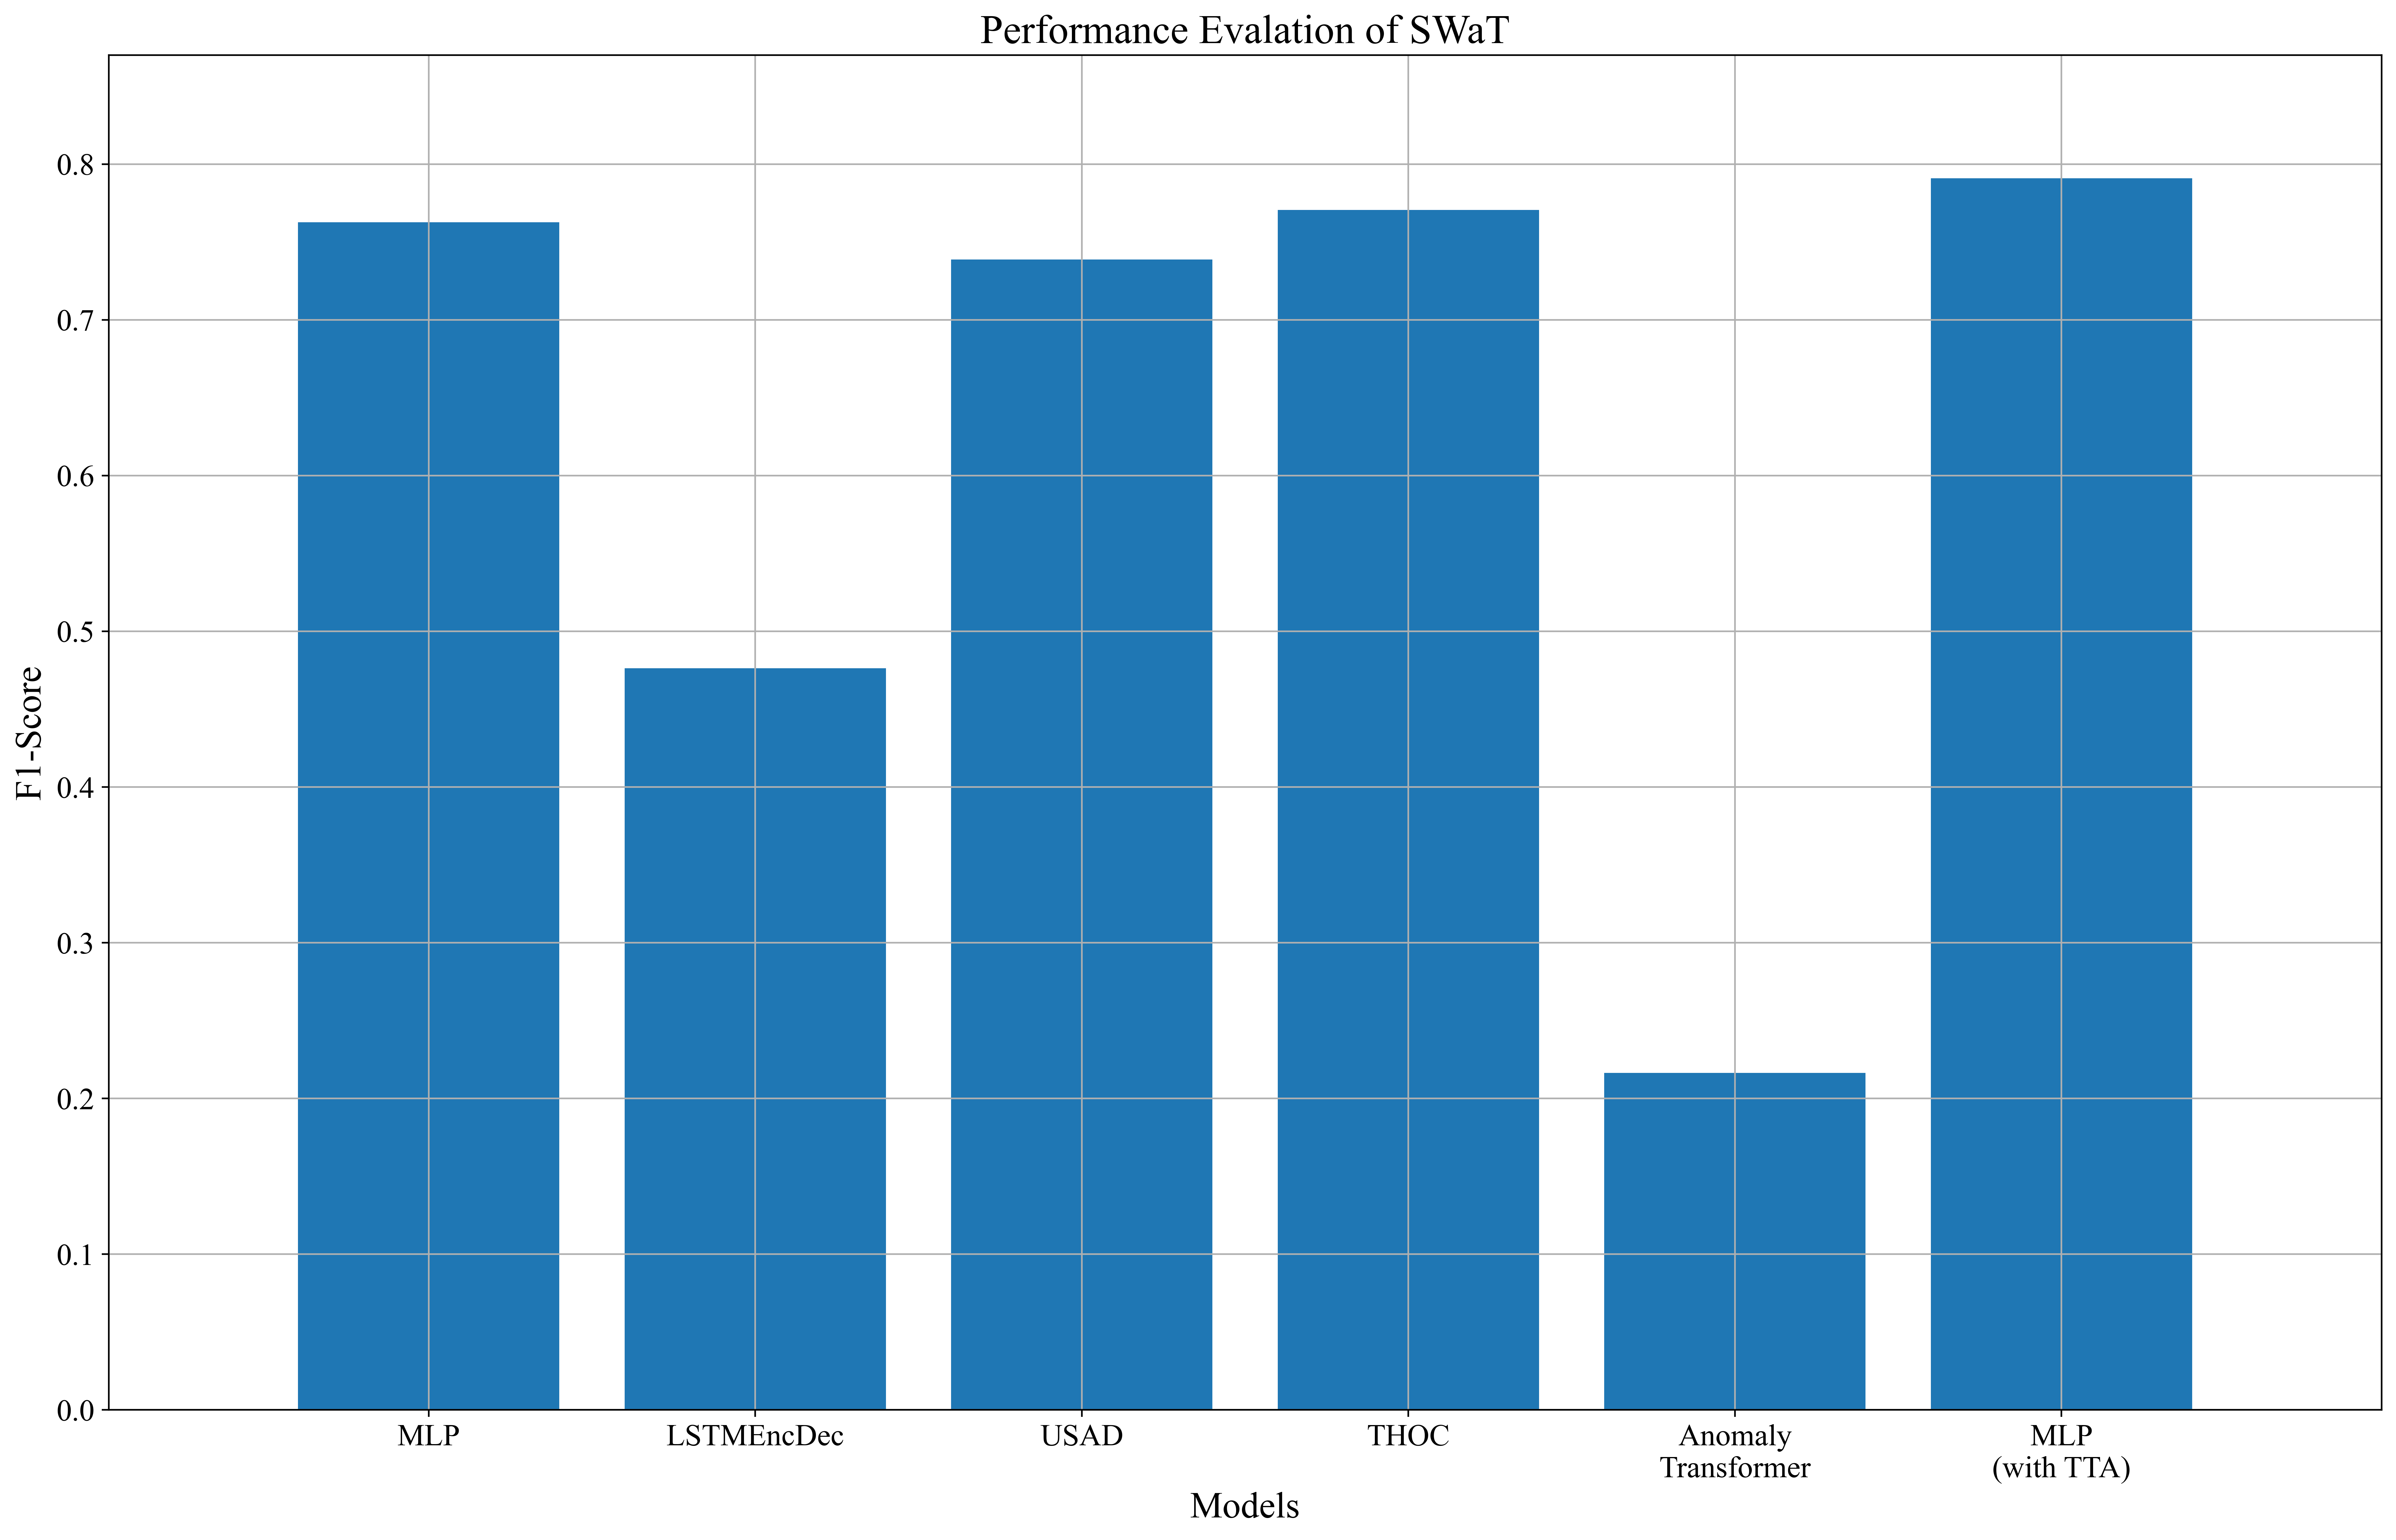

In [38]:
# Basic Bar Chart


plt.bar(models, F1s)
plt.title('Performance Evalation of SWaT', fontsize=20)
plt.xlabel('Models', fontsize=18)
plt.ylabel('F1-Score', fontsize=18)
plt.show()

In [ ]:
# result summary
print(test_y.shape, preds.shape)
result = get_summary_stats(test_y, preds)
print(result)

In [ ]:
s, e = 0, -1
plt.figure(figsize=(20, 6), dpi=500)
plt.title(f"online_label_bce_joint_{args.dataset}")
plt.ylim([-1, 5])
plt.plot(anoscs_prev[s:e], color="blue", label="anomaly score w/o online learning")
plt.plot(anoscs[s:e], color="green", label="anomaly score w/ online learning")
plt.axhline(th_q95, color="purple", label="train 95% threshold")
plt.plot(thrs[s:e], color="black",label="dynamic threshold")

plot_interval(plt, test_y[s:e])
plot_interval(plt, preds.astype(int)[s:e], facecolor="gray", alpha=0.5)
plt.legend()
plt.show()

In [ ]:
# plot recon
c = 0
for c in range(args.num_channels):
    test_X, test_y = test_dataset.X, test_dataset.y

    B, L, C = Xhats.shape

    plt.figure(figsize=(20, 6), dpi=500)
    plt.title(f"online_us_bce_joint_{args.dataset}_channel_{c}")

    plt.plot(test_X[:, c], color="black", label="gt")
    plt.plot(Xhats_prev[:,:,c].reshape(-1), color="blue", label="reconed w/o online learning")
    plt.plot(Xhats[:,:,c].reshape(-1), linewidth=0.5, color="green", label="reconed w/ online learning")
    plt.legend()
    plot_interval(plt, test_y)